<a href="https://colab.research.google.com/github/Varshini151205/ML/blob/main/ML_Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix, roc_curve
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#load data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
columns = ["age","workclass","fnlwgt","education","education-num","marital-status","occupation",
           "relationship","race","sex","capital-gain","capital-loss","hours-per-week","native-country","income"]
data = pd.read_csv(url, names=columns, sep=", ", engine='python')

In [3]:
data = data.replace('?', np.nan).dropna()
for col in data.select_dtypes(include='object'):
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])

X = data.drop("income", axis=1)
y = data["income"]

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [10]:
#Baseline model
baseline = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
baseline.fit(X_train, y_train)
y_pred = baseline.predict(X_test)
y_proba = baseline.predict_proba(X_test)[:,1]

print("---- Baseline Results ----")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_proba))

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [05:24:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


---- Baseline Results ----
Accuracy: 0.8615945632355378
F1: 0.6982291290206
AUC: 0.9204491120645144


In [7]:
# Hyperparameter tuning
param_dist = {
    "n_estimators": [100, 300, 500, 800],
    "max_depth": [3, 6, 10, 15],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "gamma": [0, 0.1, 0.3, 0.5],
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rs = RandomizedSearchCV(
    XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    param_distributions=param_dist,
    n_iter=30,
    scoring='roc_auc',
    cv=cv,
    verbose=2,
    random_state=42,
    n_jobs=-1
)
rs.fit(X_train, y_train)
print("\nBest Parameters:", rs.best_params_)


Fitting 5 folds for each of 30 candidates, totalling 150 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [05:05:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Best Parameters: {'subsample': 1.0, 'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 1.0}


In [8]:
#  Evaluate tuned model
best_model = rs.best_estimator_
y_pred_tuned = best_model.predict(X_test)
y_proba_tuned = best_model.predict_proba(X_test)[:,1]

print("\n---- Tuned Model Results ----")
print("Accuracy:", accuracy_score(y_test, y_pred_tuned))
print("F1:", f1_score(y_test, y_pred_tuned))
print("AUC:", roc_auc_score(y_test, y_proba_tuned))
print("\nClassification Report:\n", classification_report(y_test, y_pred_tuned))


---- Tuned Model Results ----
Accuracy: 0.8637493784186971
F1: 0.7021739130434783
AUC: 0.9247937936646524

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.94      0.91      4531
           1       0.77      0.65      0.70      1502

    accuracy                           0.86      6033
   macro avg       0.83      0.79      0.81      6033
weighted avg       0.86      0.86      0.86      6033



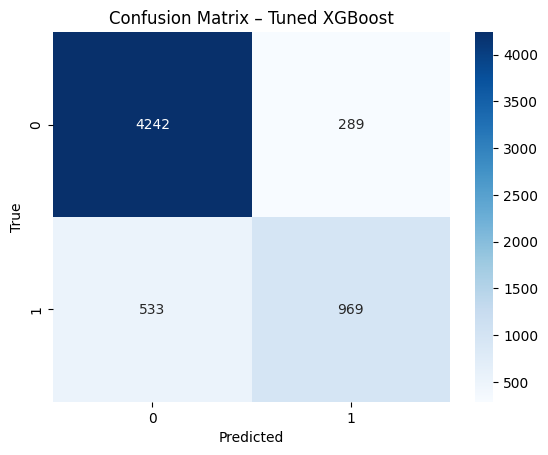

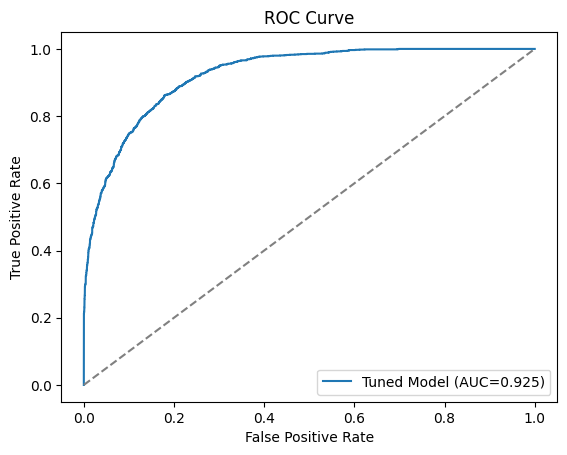

In [9]:
# Confusion matrix & ROC curve
cm = confusion_matrix(y_test, y_pred_tuned)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix – Tuned XGBoost")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_proba_tuned)
plt.plot(fpr, tpr, label="Tuned Model (AUC=%.3f)" % roc_auc_score(y_test, y_proba_tuned))
plt.plot([0,1],[0,1],'--',color='gray')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()